In [1]:
# relevant imports
import pandas as pd
import numpy as np
from collections import defaultdict

# Reading the SOEP Household data

Because the individual questionair file is quite big we will merge it soepwise with the weather and household data. Therefore we first read the hh files. All the required hh data can be found in two different data sets. These are merged in the following:

In [2]:
hbrutto_path = "./data/SOEP-CORE.v37eu_CSV/CSV/hbrutto.csv"
hl_path = "./data/SOEP-CORE.v37eu_CSV/CSV/hl.csv"

`hbrutto` contains meta data about the interviews. This includes data such as "day of interview", "location", etc. The `hl` file contains the interview responses of all waves in a long format.

In the following are the columns of interest with in the `hl` and `hbrutto` file with the corresponding meaning:

In [3]:
hl_var = [
    # keys for merging
    "syear", # survey year -> prim. key
    "hid", # hh id -> prim. key
    # hh control variables:
    "hlc0005_h", #[de] Monatliches HH-Netto-Einkommen [harmonisiert]
    "hlc0043", # Number Children
    "hlf0001_h", # Homewonership
    "hlk0056" # Type of interview
] # 

hbrutto_var = [
    "syear",  # survey year -> prim. key
    "hid",  # hh id -> prim. key
    "bula_h" # location -> bundesland
]

The two files are now read in to their respective dataframe.

In [4]:
df_hl = pd.read_csv(hl_path, usecols=hl_var, dtype=np.int32)

In [5]:
df_hbrutto = pd.read_csv(hbrutto_path, usecols=hbrutto_var, dtype=np.int32)

The two dataframes can now be merged on their primary key. According to the documentation of the db the prim. keys are `hid` and `syear`.

In [6]:
df_hh = df_hl.merge(df_hbrutto, how="inner", on=["hid", "syear"])
del df_hl, df_hbrutto

# Reading the SOEP Individual Data

Now we read the individual data. This dataset includes the target variable *SWB* as well as many other control variables. The datasets that contain the information used in this analysis are `ppathl` (tracking file) and `pl` (data)

In [7]:
ppathl_path = "./data/SOEP-CORE.v37eu_CSV/CSV/ppathl.csv"
pequiv_path = "./data/SOEP-CORE.v37eu_CSV/CSV/pequiv.csv"
pl_path = "./data/SOEP-CORE.v37eu_CSV/CSV/pl.csv"

In [8]:
ppathl_var = [
    "pid", # person id -> prim. key
    "syear", #survey year -> prim. key
    # relevant covariates
    "sex", # gender [1] female [2] male
    "gebjahr", # year of birth
    "partner" # [0] no partner, [1] spouse, [2] partner,
              # [3] Probably spouse, [4] probably partner
    # NOTE: join 1&3 and 2&4
]

pequiv_var = [
    "pid", # person id -> prim. key
    "syear", #survey year -> prim. key
    "d11109", #years of education: Year of eduction: numerical
    # NOTE: many nan values
    "m11124", # Disability status: [0] Not Disabled, [1] Disabled
    "e11103" # Labor Participation: [1] Full Time, [2] Part Time, [3] Not Working, [-1] younger than 16
]

pl_var = [
    # ids
    "pid",  # person id -> prim. key
    "syear",  #survey year -> prim. key
    "hid",  # hh id -> prim. key
    # target variable
    "plh0182", # Current life satisfaction [0-10]
    # relevant covariates
    "ptagin",  # day of interview
    "pmonin",  # month of interview
    "plh0171",  # Current Health: [1-10] (1=schlecht, 10=gut)
    "plb0021",  # Arbeitslos gemeldet: [2] No [1] Yes
    # NOTE: take max of plh0173 and plh0174
    "plh0175" # Satisfaction With Household Income
]

The `ppathl` contains the tracking data of a person. This includes for instance the age or marital status.

In [9]:
df_ppathl = pd.read_csv(ppathl_path, usecols=ppathl_var)

In [10]:
df_pequiv = pd.read_csv(pequiv_path, usecols=pequiv_var)

In the following we merge all the dataframes loaded into memory.

In [11]:
soep = pd.read_csv(pl_path, usecols=pl_var)

## MERGE WITH OTHER DATASETS
# merge with tracking data
soep = soep.merge(df_ppathl, on=["syear", "pid"], how="inner")
del df_ppathl
# merge with pequiv (TODO what is this table)
soep = soep.merge(df_pequiv, on=["syear", "pid"], how="inner")
del df_pequiv
# merge with household
soep = soep.merge(df_hh, on=["syear", "hid"], how="inner")
del df_hh

## CALCULATE RELEVANT VARIABLES
# time stamp:
soep.rename({'syear':"year", 'pmonin':"month", 'ptagin':"day"}, axis=1, inplace=True)

## PRINT EXAMPLE
soep

,pid,hid,year,plb0021,plh0171,plh0175,plh0182,month,day,partner,sex,gebjahr,d11109,e11103,m11124,hlc0005_h,hlc0043,hlf0001_h,hlk0056,bula_h
0,101,19,1984,-8,8,8,8,-8,-8,1,1,1930,15.0,1,0,1559,-8,1,-8,11
1,102,19,1984,-8,7,7,8,-8,-8,1,2,1940,9.0,3,0,1559,-8,1,-8,11
2,103,19,1984,-8,8,5,8,-8,-8,0,1,1963,12.0,1,0,1559,-8,1,-8,11
3,201,27,1984,-8,10,10,10,-8,-8,0,2,1926,10.5,3,0,733,-8,1,-8,11
4,202,27,1984,-8,-2,-2,-2,-8,-8,0,2,1956,-2.0,3,0,733,-8,1,-8,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741967,55395401,5539546,2020,-5,7,-5,7,12,19,0,2,1993,7.0,3,-5,500,-2,-2,9,5
741968,55396001,5539600,2020,-5,9,-5,7,10,6,0,1,2001,-2.0,3,-5,320,-2,-2,9,11
741969,55396601,5539660,2020,-5,6,-5,7,12,12,0,2,1981,7.0,3,-5,1600,-2,1,0,11
741970,55402001,5540200,2020,-5,6,-5,4,10,30,1,1,1988,7.0,3,-5,700,-2,2,9,5


# Data Cleanup

Most of the variables need some manual preparation when it comes to negative values. The conventions for missing values in SOEP is:

| Code | Label                                              | 
|------|----------------------------------------------------|
| -1   | No answer / don’t know                             |
| -2   | Does not apply                                     |
| -3   | Implausible value                                  |
| -4   | Inadmissable multiple response                     |
| -5   | Not included in this version of the questionnaire  |
| -6   | Version of questionnaire with modified filtering   |
| -7   | Only available in less restricted edition          |
| -8   | Question not part of the survey program this year  |



In [12]:
import matplotlib.pyplot as plt

%matplotlib inline

In [13]:
treated = ['pid', 'syear', 'pmonin', 'ptagin']
all_vars = hbrutto_var + hl_var + ppathl_var + pequiv_var + pl_var

The `bula_h` variable is used to merge with other data. Therefore we must ensure that it is not negative.

In [14]:
soep = soep[(soep['month'] >= 1) & (soep['bula_h'] >= 1) & (soep['day'] >= 1)]
treated.append(['year', 'month'])

The number of children is a numerical value. If a person did not have children the value is $-2$. This is changed to 0.
All the other values are nan values. However, since the number of children does not change ofter, we can fill nan values with earlier observations.

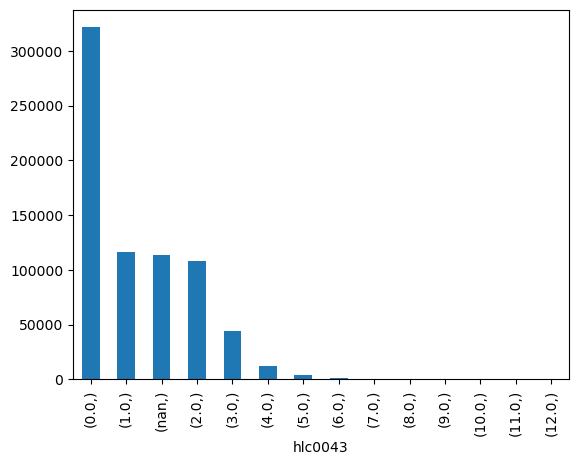

In [15]:
soep.loc[soep['hlc0043']==-2, 'hlc0043'] += 2
soep.loc[soep['hlc0043'] < 0, 'hlc0043'] = np.nan
#soep['hlc0043'] = soep['hlc0043'].fillna(method='ffill')
soep[['hlc0043']].value_counts(dropna=False).plot(kind='bar')
treated.append('hlc0043')

The partner variable also has some redundant values. We have that $[3] \approx [1]$ and $[4] \approx [2]$. Furthermore, we have that $[5]$ stands for "unsure". 
Therefore, $[5]$ will be set to nan. 

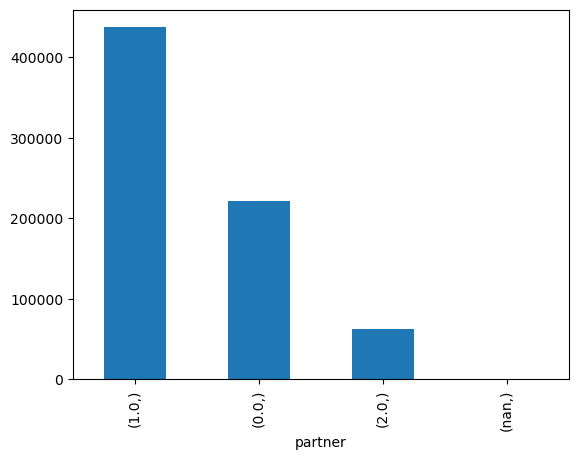

In [16]:
# clean values
soep.loc[soep['partner'] == 3, 'partner'] = 1
soep.loc[soep['partner'] == 4, 'partner'] = 2
# the rest is nan
soep.loc[(soep['partner'] == 5) | (soep['partner'] < 0), 'partner'] = np.nan
soep[['partner']].value_counts(dropna=False).plot(kind='bar')
treated.append('partner')

With year of birth negative values are missing. We can use this variable to calculate the age of each person. Each age that is over 120 is concidered an outlier.

/tmp/ipykernel_27097/4226979746.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soep.loc[:, "age"] = soep.loc[:,'year'] - soep.loc[:,"gebjahr"]


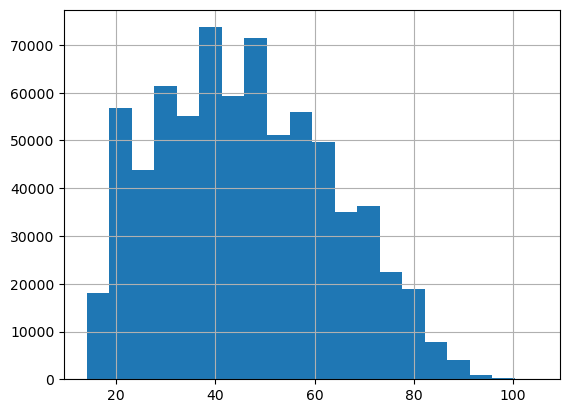

In [17]:
soep.loc[soep['gebjahr'] < 1800, 'gebjahr'] = np.nan
soep.loc[:, "age"] = soep.loc[:,'year'] - soep.loc[:,"gebjahr"]
soep.loc[soep["age"] > 120, "age"] = np.nan
soep['age'].hist(bins=20)
treated.append(['age', 'gebjahr'])

Years of education can also be padded with old values. 

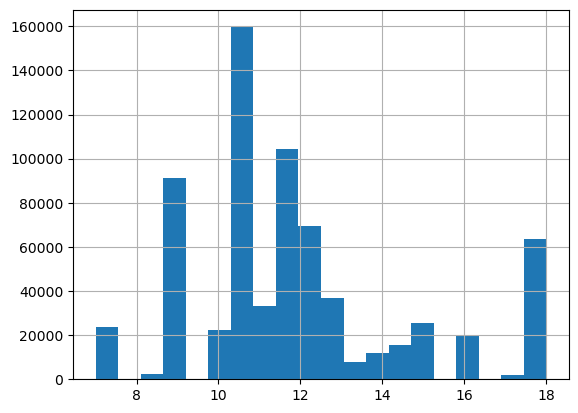

In [18]:
soep.loc[soep['d11109'] < 0, 'd11109'] = np.nan
#soep['d11109'] = soep['d11109'].fillna(method='ffill', limit=2)
soep['d11109'].hist(bins=20)
treated.append('d11109')

In employment level of individual $[-1]$ also carries information. Namely does it mean that the individual is less than 16 years old. The other negative values are nan.

In [19]:
soep.loc[soep['e11103'] < -1, 'e11103'] = np.nan
treated.append('e11103')

Most other variables have the nan value $[-2]$ which stands for "does not apply". That value is then mostly calculated by the situation of that person. For instance a child cannot be unemployed. Therefore $[-2]$ should not be interpreted as nan values. The other negative values mostly do not carry any information.

In [20]:
for var in [x for x in all_vars if x not in treated]:
    soep.loc[(soep[var] < 0) & (soep[var] != -2), var] = np.nan

Save the dataframe

In [21]:
soep.to_parquet("./prod/soeplong.parquet.snappy", index=False)
soep

,pid,hid,year,plb0021,plh0171,plh0175,plh0182,month,day,partner,...,gebjahr,d11109,e11103,m11124,hlc0005_h,hlc0043,hlf0001_h,hlk0056,bula_h,age
12290,101,19.0,1985,2.0,8.0,8.0,8.0,3,21,1.0,...,1930.0,15.0,1.0,0.0,NaN,NaN,1.0,3.0,11.0,55.0
12291,102,19.0,1985,NaN,8.0,8.0,8.0,3,21,1.0,...,1940.0,9.0,3.0,0.0,NaN,NaN,1.0,3.0,11.0,45.0
12292,103,60305.0,1985,2.0,10.0,7.0,8.0,5,22,0.0,...,1963.0,12.0,1.0,0.0,1790.0,NaN,1.0,3.0,11.0,22.0
12293,201,27.0,1985,2.0,5.0,5.0,10.0,3,21,0.0,...,1926.0,10.5,3.0,1.0,665.0,NaN,1.0,3.0,11.0,59.0
12294,202,27.0,1985,2.0,10.0,10.0,9.0,3,21,0.0,...,1956.0,18.0,2.0,0.0,665.0,NaN,1.0,3.0,11.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741967,55395401,5539546.0,2020,NaN,7.0,NaN,7.0,12,19,0.0,...,1993.0,7.0,3.0,NaN,500.0,0.0,-2.0,9.0,5.0,27.0
741968,55396001,5539600.0,2020,NaN,9.0,NaN,7.0,10,6,0.0,...,2001.0,NaN,3.0,NaN,320.0,0.0,-2.0,9.0,11.0,19.0
741969,55396601,5539660.0,2020,NaN,6.0,NaN,7.0,12,12,0.0,...,1981.0,7.0,3.0,NaN,1600.0,0.0,1.0,0.0,11.0,39.0
741970,55402001,5540200.0,2020,NaN,6.0,NaN,4.0,10,30,1.0,...,1988.0,7.0,3.0,NaN,700.0,0.0,2.0,9.0,5.0,32.0
